In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import os
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import random
import smtplib
from scipy.ndimage.interpolation import rotate
from scipy import misc
from planar import BoundingBox
from PIL import ImageEnhance
from PIL import Image
%matplotlib inline
print "Done"

Done


In [2]:
training_metadata = np.load("train_metadata.npy")
training_metadata = training_metadata[()]

In [3]:
# models value
N_CHANNELS=1
NUM_DIGITS=5
NUM_LABELS=11 # 0-9 the blank character
SEED=987
MODEL_INPUT_IMAGE_SIZE=54
INITIAL_LEARNING_RATE = 3e-5        # Initial learning rate.
MODEL_FOLDER_NAME="new_batch_function_lr_" + str(INITIAL_LEARNING_RATE)
SHUFFLE_DATASET_PER_EPOCH=5
BATCH_SIZE=86
TOTAL_NUM_OF_EPOCHES = 120
MAX_NUMBER_OF_LABELS=5
PIXEL_DEPTH=255.0
MODEL_INPUT_IMAGE_SIZE=54

In [4]:
MINIBATCH_EVAL_STEPS=500

In [5]:
def random_crop(img,width,height):
    aa = random.randrange(0,11)
    cc = random.randrange(0,11)
    return img[aa:(width+aa), cc:(height+cc)]  

In [6]:
def read_image_from_disk(image_path):
    # read the image from disk
    try:
        original_img = misc.imread("./" + image_path, mode ="L")
    except IOError as e:
        print("Oops! Problem reading that image, lets skip it.")
        original_img = None
    return original_img

In [7]:
def rotate_img(img, degrees):
    # get a random value 
    d = random.randrange(-degrees,degrees,2)
    
    rotated = rotate(img, d, reshape=False, mode="nearest")
    return rotated

In [8]:
def distort_image(img):
    pil_image = Image.fromarray(img)

    # appy random Brightness
    factor = random.uniform(0.4, 1.0)
    enhancer = ImageEnhance.Brightness(pil_image)
    distorted_image = enhancer.enhance(factor)

    # apply random Contrast
    factor = random.uniform(0.4, 1.0)
    enhancer = ImageEnhance.Contrast(distorted_image)
    distorted_image = enhancer.enhance(factor)

    # apply random blur
    sharpness_factor = random.uniform(0.2, 1.0)
    enhancer = ImageEnhance.Sharpness(distorted_image)
    distorted_image = enhancer.enhance(sharpness_factor)

    # convert to numpy image
    img = np.array(distorted_image)
    return img

In [9]:
def get_batch_data_and_labels(iteration_step, batch_size, train_data_size, image_size, image_names, label_names, images_bboxes, expand_bbox=False, training=False):
    
    if train_data_size % batch_size != 0:
        print "Error, please provide a batch_size value that is factor of", train_data_size
    
    dataset_id = 0
    dataset = np.zeros(shape=(batch_size, image_size, image_size, N_CHANNELS), dtype=np.float32)
    labels = np.zeros(shape=(batch_size, MAX_NUMBER_OF_LABELS), dtype=np.int8)
    offset = (iteration_step * batch_size) % (train_data_size)
    for img_id in range(offset, offset + batch_size):

        # get the image file name and label
        img_name = image_names[img_id]
        img_labels = list(label_names[img_id])
        
        # if the image has more than [MAX_NUMBER_OF_LABELS] digits, discard it
        if len(img_labels) > MAX_NUMBER_OF_LABELS:
            print "Discarding image:", img_name, "\tMore than:", MAX_NUMBER_OF_LABELS, "digits."
            continue
        
        original_img = read_image_from_disk(img_name)
        if original_img is None:
            continue

        # get the image size
        img_h = original_img.shape[0]
        img_w = original_img.shape[1]

        # read the bbox data
        aa, bb, cc, dd = map(int, images_bboxes[img_id])

        # create bbox
        bbox = BoundingBox([(cc,aa), (dd,bb)])

        # make the bboxes squared
        if bbox.width > bbox.height:
            needed_value =  bbox.width - bbox.height
            max_height = min(aa, (img_h-bb)) 
            if (needed_value) <= max_height:
                bbox = bbox.inflate((0, needed_value))
            else:
                bbox = bbox.inflate((0,max_height)) 
        elif bbox.width < bbox.height:
            max_width = min(cc, (img_w-dd)) 
            needed_value =  bbox.height - bbox.width
            if (needed_value) <= max_width:
                bbox = bbox.inflate((needed_value,0))
            else:
                bbox = bbox.inflate((max_width,0)) 
    
        # try to expand the bbox to a maximum of 30%
        # get the maximum height and width size the bbox can expand to
        max_height = min(aa, (img_h-bb)) 
        
        if dd > img_w: dd = img_w
        max_width = min(cc, (img_w-dd))
        
        if expand_bbox == True:
            # get the measures for a 30% increase
            width_expand = bbox.width * 0.3
            height_expand = bbox.height * 0.3

            # if the bbox can increase to more than 30%, make it be 30%
            if max_height > height_expand:
                max_height = height_expand
            if max_width > width_expand:
                max_width = width_expand

            # get the max value the bbox can expand equally in both side
            value = min(max_height, max_width)
            bbox = bbox.inflate(value)
            ## end expand ##

            if aa < 0:
                exit(1)
        
        # get the bbox individual values
        cc, aa = map(int,list(bbox.min_point))
        dd, bb = map(int,list(bbox.max_point))
    
        if training == True:
            r = random.randrange(0, 2)
            if r == 1:
                original_img = rotate_img(original_img, degrees=20)
    
        # crop and resize the images to the bboxes
        img = original_img[aa:bb, cc:dd]   

        if training == True:
            img = distort_image(img)
        
        try:
            if training == True:
                expanding_factor = 10
                img = misc.imresize(img,(image_size + expanding_factor, image_size + expanding_factor))
                img = random_crop(img, image_size, image_size)
            else:
                img = misc.imresize(img,(image_size, image_size))
                
            # normalize the image
            img = (img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH   
            dataset[dataset_id] = img.reshape(image_size,image_size,N_CHANNELS)
            
        except ValueError as e:
            print "Bbox:", aa, bb, cc, dd
            print "Image Index: ", img_id
            print "Image shape:", img.shape

        # append the label 10 for images with less than MAX_NUMBER_OF_LABELS digits on it
        while len(img_labels) < MAX_NUMBER_OF_LABELS:
            img_labels = np.append(img_labels, 10)

        labels[dataset_id] = img_labels
        dataset_id += 1

    return dataset, labels


In [10]:
def display_images_at_random(dataset, labels):
    f, axarr = plt.subplots(3, 4, figsize=(14,10))
    
    for i in range(3):
        for j in range(4):
            img_rand_index = random.randrange(0,dataset.shape[0])
            img  = dataset[img_rand_index]
            axarr[i, j].imshow(img.reshape(img.shape[0],img.shape[1]), cmap=plt.cm.Greys);
            axarr[i, j].set_title('Label: ' + str(labels[img_rand_index]) + " ID: " + str(img_rand_index))

    plt.show()

In [11]:
train_image_names = training_metadata["train_image_names"]
train_labels = training_metadata["train_labels"]
train_bboxes = training_metadata["train_bboxes"]
train_n_bboxes = training_metadata["train_n_bboxes"]

In [12]:
VALID_DATASET_SIZE=10004
TRAIN_DATASET_SIZE = train_image_names.shape[0] - VALID_DATASET_SIZE

valid_image_names = train_image_names[:VALID_DATASET_SIZE]
valid_labels = train_labels[:VALID_DATASET_SIZE]
valid_bboxes = train_bboxes[:VALID_DATASET_SIZE]
valid_n_bboxes = train_n_bboxes[:VALID_DATASET_SIZE]

train_image_names =  train_image_names[VALID_DATASET_SIZE:]
train_labels =  train_labels[VALID_DATASET_SIZE:]
train_bboxes =  train_bboxes[VALID_DATASET_SIZE:]
train_n_bboxes =  train_n_bboxes[VALID_DATASET_SIZE:]

In [13]:
valid_dataset, valid_labels = get_batch_data_and_labels(0, VALID_DATASET_SIZE, VALID_DATASET_SIZE, 54, valid_image_names, valid_labels, valid_bboxes, expand_bbox=True, training=False)

In [14]:
VALID_DATASET_SIZE=valid_dataset.shape[0]

In [15]:
print "Validation set", valid_dataset.shape
print "Validation labels", valid_labels.shape

Validation set (10004, 54, 54, 1)
Validation labels (10004, 5)


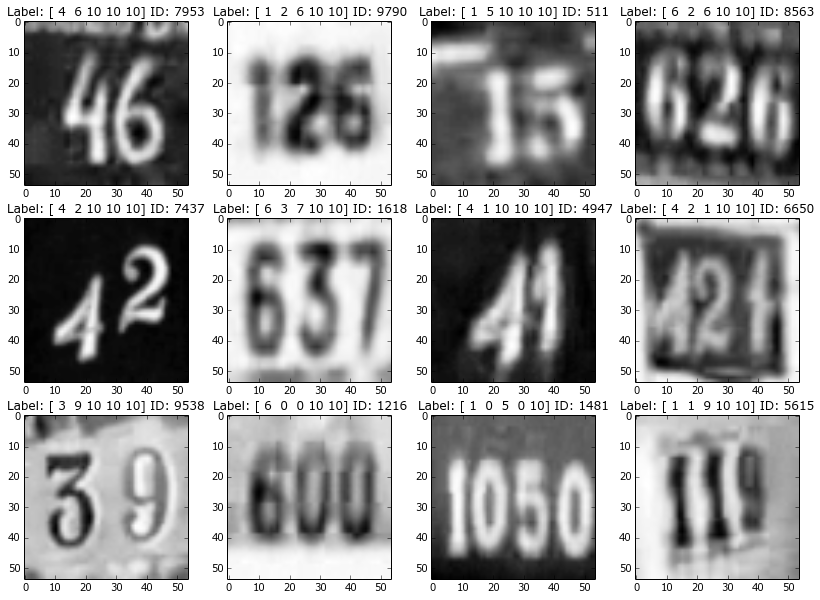

In [16]:
display_images_at_random(valid_dataset, valid_labels)

In [17]:
def randomize(dataset, permutation):
  shuffled_dataset = dataset[permutation]
  return shuffled_dataset

In [18]:
def shuffle_dataset(train_image_names, train_labels, train_bboxes, train_n_bboxes):
    permutation = np.random.permutation(train_image_names.shape[0])

    # randomize the dataset
    train_image_names = randomize(train_image_names, permutation)
    train_labels = randomize(train_labels, permutation)
    train_bboxes = randomize(train_bboxes, permutation)
    train_n_bboxes = randomize(train_n_bboxes, permutation)
    return train_image_names, train_labels, train_bboxes, train_n_bboxes

In [19]:
def weight_variable(shape, stddev=1e-1):
  initial = tf.truncated_normal(shape, stddev=stddev,seed=SEED)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(value=0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x, strides=[1, 2, 2, 1]):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=strides, padding='SAME')

In [20]:
x = tf.placeholder(tf.float32, shape=[None, MODEL_INPUT_IMAGE_SIZE, MODEL_INPUT_IMAGE_SIZE, N_CHANNELS], name="input_placeholder")
y_ = tf.placeholder(tf.int32, shape=[None, NUM_DIGITS], name="labels_placeholder")

tf_valid_dataset = tf.placeholder(tf.float32, shape=[None, MODEL_INPUT_IMAGE_SIZE, MODEL_INPUT_IMAGE_SIZE, N_CHANNELS], name="test_placeholder")

In [21]:
# Variables definitions
CONV1_DEPTH=16
W_conv1 = weight_variable([5, 5, N_CHANNELS, CONV1_DEPTH], stddev=0.1)
b_conv1 = bias_variable([CONV1_DEPTH])

CONV2_DEPTH=32
W_conv2 = weight_variable([5, 5, CONV1_DEPTH, CONV2_DEPTH], stddev=0.08)
b_conv2 = bias_variable([CONV2_DEPTH])

CONV3_DEPTH=48
W_conv3 = weight_variable([5, 5, CONV2_DEPTH, CONV3_DEPTH], stddev=0.06)
b_conv3 = bias_variable([CONV3_DEPTH])

CONV4_DEPTH=64
W_conv4 = weight_variable([5, 5, CONV3_DEPTH, CONV4_DEPTH], stddev=0.04)
b_conv4 = bias_variable([CONV4_DEPTH])

CONV5_DEPTH=80
W_conv5 = weight_variable([5, 5, CONV4_DEPTH, CONV5_DEPTH], stddev=0.02)
b_conv5 = bias_variable([CONV5_DEPTH])

CONV6_DEPTH=96
W_conv6 = weight_variable([5, 5, CONV5_DEPTH, CONV6_DEPTH], stddev=0.009)
b_conv6 = bias_variable([CONV6_DEPTH])

CONV7_DEPTH=112
W_conv7 = weight_variable([5, 5, CONV6_DEPTH, CONV7_DEPTH], stddev=0.007)
b_conv7 = bias_variable([CONV7_DEPTH])

FC1_SIZE = 1024
W_fc1 = weight_variable([4 * 4 * CONV7_DEPTH, FC1_SIZE], stddev=0.003)
b_fc1 = bias_variable([FC1_SIZE])

FC2_SIZE = 1024
W_fc2 = weight_variable([FC1_SIZE, FC2_SIZE], stddev=0.003)
b_fc2 = bias_variable([FC2_SIZE])

FC3_SIZE = 1024
W_fc3 = weight_variable([FC2_SIZE, FC3_SIZE], stddev=0.003)
b_fc3 = bias_variable([FC3_SIZE])

read_output_layer_digit_1 = weight_variable([FC3_SIZE, NUM_LABELS], stddev=1.0/FC3_SIZE)
read_output_bias_digit_1 = bias_variable([NUM_LABELS])

read_output_layer_digit_2 = weight_variable([FC3_SIZE, NUM_LABELS], stddev=1.0/FC3_SIZE)
read_output_bias_digit_2 = bias_variable([NUM_LABELS])

read_output_layer_digit_3 = weight_variable([FC3_SIZE, NUM_LABELS], stddev=1.0/FC3_SIZE)
read_output_bias_digit_3 = bias_variable([NUM_LABELS])

read_output_layer_digit_4 = weight_variable([FC3_SIZE, NUM_LABELS], stddev=1.0/FC3_SIZE)
read_output_bias_digit_4 = bias_variable([NUM_LABELS])

read_output_layer_digit_5 = weight_variable([FC3_SIZE, NUM_LABELS], stddev=1.0/FC3_SIZE)
read_output_bias_digit_5 = bias_variable([NUM_LABELS])
print "Done"

Done


In [27]:
# model
def model(x_image, training=False):

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    if (training == True):
        norm1 = tf.nn.dropout(norm1, 0.85, seed=SEED)
    
    h_conv2 = tf.nn.relu(conv2d(norm1, W_conv2) + b_conv2)
    norm2 = tf.nn.lrn(h_conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    h_pool2 = max_pool_2x2(norm2, strides=[1,1,1,1])
    if (training == True):
        h_pool2 = tf.nn.dropout(h_pool2, 0.86, seed=SEED)
    
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    norm3 = tf.nn.lrn(h_pool3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm3')
    if (training == True):
        norm3 = tf.nn.dropout(norm3, 0.87, seed=SEED)
    
    h_conv4 = tf.nn.relu(conv2d(norm3, W_conv4) + b_conv4)
    norm4 = tf.nn.lrn(h_conv4, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm4')
    h_pool4 = max_pool_2x2(norm4, strides=[1,1,1,1])
    if (training == True):
        h_pool4 = tf.nn.dropout(h_pool4, 0.88, seed=SEED)
    
    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = max_pool_2x2(h_conv5)
    norm5 = tf.nn.lrn(h_pool5, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm5')
    if (training == True):
        norm5 = tf.nn.dropout(norm5, 0.89, seed=SEED)
    
    h_conv6 = tf.nn.relu(conv2d(norm5, W_conv6) + b_conv6)
    norm6 = tf.nn.lrn(h_conv6, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm6')
    h_pool6 = max_pool_2x2(norm6, strides=[1,1,1,1])
    if (training == True):
        h_pool6 = tf.nn.dropout(h_pool6, 0.90, seed=SEED)
    
    h_conv7 = tf.nn.relu(conv2d(h_pool6, W_conv7) + b_conv7)
    h_pool7 = max_pool_2x2(h_conv7)
    norm7 = tf.nn.lrn(h_pool7, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm7')
    if (training == True):
        norm7 = tf.nn.dropout(norm7, 0.91, seed=SEED)
        
    shape = norm7.get_shape().as_list()
    h_pool_flat = tf.reshape(norm7, [-1, shape[1] * shape[2] * shape[3]])
    
    # First fully connected layer
    h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)
    if (training == True):
        h_fc1 = tf.nn.dropout(h_fc1, 0.92, seed=SEED)

    # Second fully connected layer
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    if (training == True):
        h_fc2 = tf.nn.dropout(h_fc2, 0.93, seed=SEED)

    # Third fully connected layer
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)
    if (training == True):
        h_fc3 = tf.nn.dropout(h_fc3, 0.94, seed=SEED)

    # digit #1
    digit_1 = tf.matmul(h_fc3, read_output_layer_digit_1) + read_output_bias_digit_1

    # digit #2
    digit_2 = tf.matmul(h_fc3, read_output_layer_digit_2) + read_output_bias_digit_2
    
    # digit #3
    digit_3 = tf.matmul(h_fc3, read_output_layer_digit_3) + read_output_bias_digit_3

    # digit #4
    digit_4 = tf.matmul(h_fc3, read_output_layer_digit_4) + read_output_bias_digit_4

    # digit #5
    digit_5 = tf.matmul(h_fc3, read_output_layer_digit_5) + read_output_bias_digit_5
    
    return digit_1, digit_2, digit_3, digit_4, digit_5

Display some of the images just to make sure everything is fine

In [28]:
# logits = model(x, True)
logits_d1, logits_d2, logits_d3, logits_d4, logits_d5 = model(x, True)

loss_d1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_d1, y_[:,0]))
loss_d2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_d2, y_[:,1]))
loss_d3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_d3, y_[:,2]))
loss_d4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_d4, y_[:,3]))
loss_d5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_d5, y_[:,4]))

# apply L2 regularization of the trained weights
regularizers = (tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
                 tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2) +
                 tf.nn.l2_loss(W_fc3) + tf.nn.l2_loss(b_fc3))

loss_d1 += 5e-4 * regularizers
loss_d2 += 5e-4 * regularizers
loss_d3 += 5e-4 * regularizers
loss_d4 += 5e-4 * regularizers
loss_d5 += 5e-4 * regularizers

total_loss = loss_d1 + loss_d2 + loss_d3 + loss_d4 + loss_d5

loss_summary = tf.scalar_summary('loss', total_loss)

optimizer = tf.train.AdamOptimizer(INITIAL_LEARNING_RATE, epsilon=1e-05).minimize(total_loss)

# Predictions for the minibatch, validation set and test set.
train_pred = tf.pack([tf.nn.softmax(logits_d1), 
                     tf.nn.softmax(logits_d2),
                     tf.nn.softmax(logits_d3), 
                     tf.nn.softmax(logits_d4),
                     tf.nn.softmax(logits_d5)])
train_pred = tf.transpose(train_pred, perm=[1, 0, 2])

print "Done"

Done


In [29]:
valid_logits_d1, valid_logits_d2, valid_logits_d3, valid_logits_d4, valid_logits_d5 = model(tf_valid_dataset, False)
valid_pred = tf.pack([tf.nn.softmax(valid_logits_d1), 
                     tf.nn.softmax(valid_logits_d2), 
                     tf.nn.softmax(valid_logits_d3), 
                     tf.nn.softmax(valid_logits_d4),
                     tf.nn.softmax(valid_logits_d5)])
valid_pred = tf.transpose(valid_pred, perm=[1, 0, 2])

In [30]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
merged = tf.merge_summary([loss_summary])
train_writer = tf.train.SummaryWriter('./summary/' + MODEL_FOLDER_NAME , s.graph)

# Initialize all the variables we defined above.
init = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

s.run(init)

In [31]:
def transcription_accuracy(predictions, labels):
  return 100. - transcription_error(predictions, labels)

In [26]:
def reformat(input_labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    index = 0
    input_labels_one_hot = np.zeros(shape=(input_labels.shape[0], 5, 11), dtype=np.float32)
    for labels in input_labels:
        for l in labels:
            one_hot_array = (np.arange(NUM_LABELS) == labels[:,None]).astype(np.float32)
        input_labels_one_hot[index] = one_hot_array
        index += 1

    return input_labels_one_hot

In [27]:
def transcription_error(predictions, labels):
    res = np.argmax(predictions,2) == np.argmax(labels,2)
    err_count = 0
    id = 0
    for r in res:
        if False in r:
            #print id
            err_count += 1
        id += 1
    return 100.0 * (err_count / float(predictions.shape[0]))

In [28]:
errors = []
global_step = 0
for epoch in range(TOTAL_NUM_OF_EPOCHES):
    print "Starting epoch:", epoch
    
    for step in range(0, train_image_names.shape[0]/BATCH_SIZE):
        
        batch_data, batch_labels = get_batch_data_and_labels(step, BATCH_SIZE, TRAIN_DATASET_SIZE, 54, train_image_names, train_labels, train_bboxes, True, True)
        
        feed_dict = {x: batch_data, y_: batch_labels}
        summary, _, loss, predictions = s.run(
            [merged, optimizer, total_loss, train_pred], feed_dict=feed_dict)
        
        if global_step % 10 == 0:
            train_writer.add_summary(summary, global_step)

        if (global_step % MINIBATCH_EVAL_STEPS == 0):
            print ('Minibatch loss at step %d: %f' % (global_step, loss))
            print ('Minibatch Error: %.1f%%' % transcription_error(predictions, reformat(batch_labels)))
        global_step += 1

    valid_predictions = valid_pred.eval({tf_valid_dataset: valid_dataset})
    valid_error = transcription_error(valid_predictions, reformat(valid_labels))
    errors.append(valid_error)
    print ('Validation Error: %.1f%%' % valid_error)
    print ("End of epoch:", epoch)
    
    if epoch % SHUFFLE_DATASET_PER_EPOCH == 0 and epoch != 0:
        print "Shuffling dataset for the next epoch."
        # shuffle the datast per epoch
        train_image_names, train_labels, train_bboxes, train_n_bboxes = shuffle_dataset(train_image_names, train_labels, train_bboxes, train_n_bboxes)
    
    print ("------------------------------------------")
        
print "Done training"

Starting epoch: 0
Minibatch loss at step 0: 12.057485
Minibatch Error: 100.0%
Minibatch loss at step 500: 7.020814
Minibatch Error: 100.0%
Minibatch loss at step 1000: 6.615291
Minibatch Error: 98.8%
Minibatch loss at step 1500: 6.985266
Minibatch Error: 100.0%
Minibatch loss at step 2000: 7.055533
Minibatch Error: 100.0%
Minibatch loss at step 2500: 6.988743
Minibatch Error: 97.7%
Validation Error: 99.2%
('End of epoch:', 0)
------------------------------------------
Starting epoch: 1
Minibatch loss at step 3000: 6.785368
Minibatch Error: 98.8%
Minibatch loss at step 3500: 6.654902
Minibatch Error: 100.0%
Minibatch loss at step 4000: 6.547866
Minibatch Error: 100.0%
Minibatch loss at step 4500: 6.658602
Minibatch Error: 100.0%
Minibatch loss at step 5000: 6.880807
Minibatch Error: 100.0%
Validation Error: 98.6%
('End of epoch:', 1)
------------------------------------------
Starting epoch: 2
Minibatch loss at step 5500: 6.452458
Minibatch Error: 100.0%
Minibatch loss at step 6000: 6.2

KeyboardInterrupt: 

In [ ]:
plt.plot(errors)
plt.ylabel('some numbers')
plt.show()

In [ ]:
#saver = tf.train.Saver()
#save_path = saver.save(s, "./summary/" + MODEL_FOLDER_NAME + "/model.ckpt")
#print("Model saved in file: %s" % save_path)

In [ ]:
testing_metadata = np.load("test_metadata.npy")
testing_metadata = testing_metadata[()]

In [ ]:
test_image_names = testing_metadata["test_image_names"]
test_labels = testing_metadata["test_labels"]
test_bboxes = testing_metadata["test_bboxes"]
test_n_bboxes = testing_metadata["test_n_bboxes"]

In [ ]:
TEST_DATASET_SIZE = test_image_names.shape[0]
TEST_IMAGE_SIZE=54

In [63]:
test_dataset, test_labels = get_batch_data_and_labels(0, TEST_DATASET_SIZE, TEST_DATASET_SIZE, TEST_IMAGE_SIZE, test_image_names, test_labels, test_bboxes, expand_bbox=False, training=False)

In [64]:
print "Testing dataset:", test_dataset.shape
print "Testing labels:", test_labels.shape

Testing dataset: (13068, 54, 54, 1)
Testing labels: (13068, 5)


Label: [ 1  0  3 10 10]
Sequence length: [3]


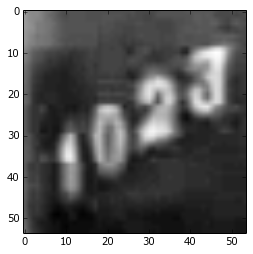

In [65]:
id = 152
img = test_dataset[id]
plt.imshow(img.reshape(54,54), cmap=plt.cm.Greys)

#print "Pred:", np.argmax(test_predictions[id],1)
print  "Label:", test_labels[id]
print  "Sequence length:", test_n_bboxes[id]

In [66]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Create a new interactive session that we'll use in
# subsequent code cells.
sess = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
sess.as_default()

# Restore variables from disk.
saver.restore(sess, "./summary/" + MODEL_FOLDER_NAME + "/model.ckpt")
print("Model restored.")

Model restored.


[ 3  6 10 10 10]
(1, 54, 54, 1)
(1, 5, 11)
[[ 3  6 10 10 10]]
Done


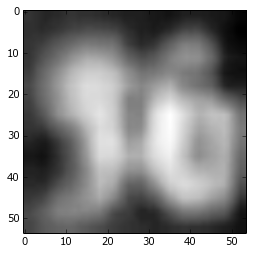

In [67]:
id = 13008
img = test_dataset[id]
print test_labels[id]
plt.imshow(img.reshape(MODEL_INPUT_IMAGE_SIZE,MODEL_INPUT_IMAGE_SIZE), cmap=plt.cm.Greys)

img  = np.reshape(img,(1,MODEL_INPUT_IMAGE_SIZE,MODEL_INPUT_IMAGE_SIZE,1))
print img.shape
seq = valid_pred.eval({tf_valid_dataset: img})

print seq.shape
print np.argmax(seq, 2)
print "Done"

In [68]:
test_predictions = valid_pred.eval({tf_valid_dataset: test_dataset})
labels = reformat(test_labels)
acc = transcription_accuracy(test_predictions, labels)
error = transcription_error(test_predictions, labels)

In [69]:
print('Test accuracy: %.1f%%' % acc)
print ('Test error: %.1f%%' % error)

Test accuracy: 93.8%
Test error: 6.2%


In [70]:
res = np.argmax(test_predictions,2) == np.argmax(labels,2)
err_count = 0
wrogly_classified = []
id = 0
for r in res:
    if False in r:
        print id
        wrogly_classified.append(id)
        err_count += 1
    id += 1

5
16
20
29
31
71
79
85
87
116
126
152
160
197
199
212
214
230
244
278
291
295
311
317
321
332
333
339
364
368
443
464
491
500
516
526
561
607
620
675
682
686
699
708
737
754
766
771
812
826
829
835
858
866
922
945
963
972
979
999
1014
1026
1034
1056
1079
1090
1098
1114
1121
1134
1143
1145
1193
1204
1251
1300
1309
1384
1401
1403
1436
1437
1499
1512
1520
1527
1538
1543
1547
1548
1549
1563
1574
1614
1626
1643
1647
1657
1676
1700
1730
1740
1749
1755
1762
1786
1792
1824
1831
1850
1855
1857
1863
1868
1871
1875
1897
1903
1905
1915
1925
1927
1955
1977
1983
2017
2024
2034
2068
2071
2077
2115
2126
2136
2190
2197
2209
2233
2235
2247
2252
2253
2260
2273
2277
2278
2310
2313
2314
2380
2381
2411
2434
2448
2469
2470
2487
2517
2531
2567
2603
2616
2629
2631
2646
2650
2682
2701
2714
2715
2719
2750
2769
2771
2775
2786
2798
2803
2804
2806
2808
2822
2839
2865
2888
2906
2934
2959
2963
2983
2998
3002
3004
3011
3059
3062
3084
3097
3101
3168
3170
3176
3178
3181
3191
3269
3272
3274
3275
3283
3335
3353
3358
3364


(13068, 5, 11)
Pred: [ 1  6  3 10 10]
Label: [ 1  3 10 10 10]


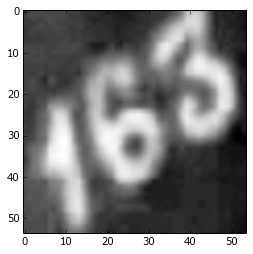

In [71]:
main_errors = [8478, 2804, 1928, 9106, 2279, 9870, 12669, 10299, 5682, 2702, 5234, 10960]

print labels.shape

id = 2701
img = test_dataset[id]
plt.imshow(img.reshape(MODEL_INPUT_IMAGE_SIZE,MODEL_INPUT_IMAGE_SIZE), cmap=plt.cm.Greys)

print "Pred:", np.argmax(test_predictions[id],1)
print  "Label:", np.argmax(labels[id],1)

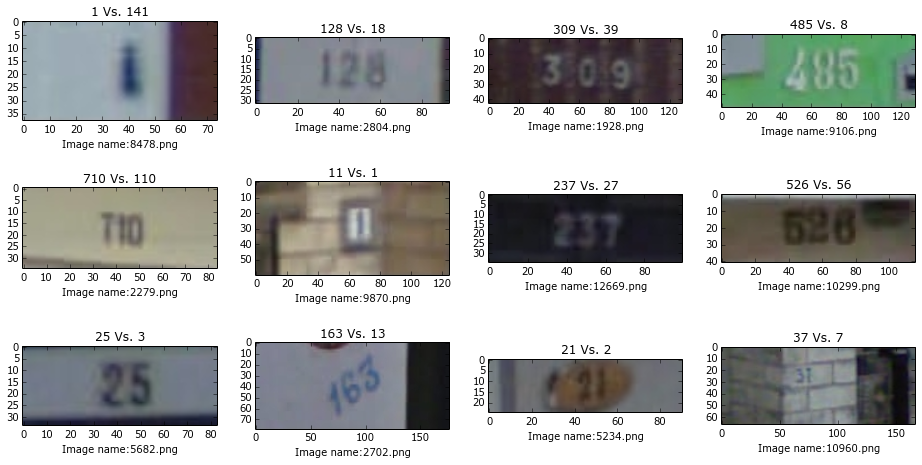

In [72]:
import matplotlib.image as mpimg
f, axarr = plt.subplots(3, 4, figsize=(16,8))

img_id = 0
for i in range(3):
    for j in range(4):
        id = main_errors[img_id]
        #id = random.randrange(0, test_dataset.shape[0])
        
        img = mpimg.imread('./test/' + str(id) + '.png')
        axarr[i, j].imshow(img);

        pred = np.argmax(test_predictions[id-1], 1)
        label = np.argmax(labels[id-1], 1)

        pred = pred[pred != 10]
        label = label[label != 10]

        pred = ''.join(str(e) for e in pred)
        label = ''.join(str(e) for e in label)

        axarr[i, j].set_title(pred + " Vs. " + label)
        axarr[i, j].set_xlabel('Image name:' + str(id) + '.png')
        img_id += 1
        
plt.show()

In [73]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def compute_per_digit_accuracy(predictions, labels, for_digit):
    index = 0
    batch = np.zeros(shape=(labels.shape[0],11), dtype=np.float32)
    pred = np.zeros(shape=(13060,11), dtype=np.float32)
    
    for digit in labels:
        print digit.shape
        batch[index] = digit[for_digit] # get s only the first digits of each image
        index += 1
    
    pred = predictions[0]
    print pred.shape
    print batch
    return accuracy(pred, batch)

In [74]:
for_digit = 1
index = 0
batch = np.zeros(shape=(labels.shape[0],11), dtype=np.float32)

for digit in labels:
    # print digit.shape
    batch[index] = digit[for_digit] # get s only the first digits of each image
    index += 1

print np.argmax(batch,1)

print predictions.shape
print np.argmax(predictions[for_digit],1)
#print np.argmax(labels[0],1)

print predictions.shape

print (100.0 * np.sum(np.argmax(predictions[for_digit], 1) == np.argmax(batch, 1))
          / predictions.shape[1])

#print compute_per_digit_accuracy(predictions, test_labels, 0)

[10  1 10 ...,  3  2  7]
(86, 5, 11)
[ 9  6 10 10 10]
(86, 5, 11)
0.0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [75]:
def compute_per_digit_error(predictions, labels, for_digit):
    index = 0
    batch = np.zeros(shape=(labels.shape[0],11), dtype=np.float32)
    for digit in labels:
        # print digit.shape
        batch[index] = digit[for_digit] # get s only the first digits of each image
        index += 1
        
    return error_rate(predictions[:,for_digit], batch)

def error_rate(predictions, labels):
  """Return the error rate and confusions."""
  correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
  total = predictions.shape[0]

  error = 100.0 - (100 * float(correct) / float(total))

  confusions = np.zeros([11, 11], np.float32)
  bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
  for predicted, actual in bundled:
    confusions[predicted, actual] += 1
    
  return error, confusions

print 'Done'

Done


In [84]:
for_digit = 3
test_error, confusions = compute_per_digit_error(test_predictions, labels, for_digit)
print test_error

0.229568411387


Done


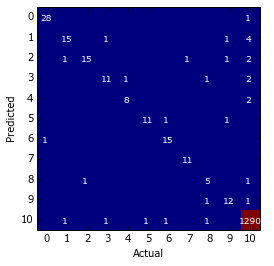

In [85]:
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
  for j, count in enumerate(cas):
    if count > 0:
      xoff = .07 * len(str(count))
      plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')
print 'Done'

In [173]:
def error(predictions, labels):
  """Return the error rate and confusions."""
  correct = accuracy(predictions, labels)
  total = predictions.shape[0]

  error = 100.0 - correct
    
  labels = reformat(labels)
  confusions = np.zeros([10, 10], np.float32)
  bundled = zip(np.argmax(np.argmax(predictions, 2).T, np.argmax(labels,2)))
  for predicted, actual in bundled:
    confusions[predicted, actual] += 1
    
  return error, confusions

print 'Done'

Done


In [174]:
test_error, confusions = error(valid_pred.eval({tf_valid_dataset: test_dataset}), test_labels)
print 'Test error: %.1f%%' % test_error

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  app.launch_new_instance()


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
print test_labels.shape
print np.argmax(test_labels, 0)

In [ ]:
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
  for j, count in enumerate(cas):
    if count > 0:
      xoff = .07 * len(str(count))
      plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')
print 'Done'

In [175]:
import scipy.misc as misc
import numpy as np

IMAGE_SIZE=56
N_CHANNELS=1
MAX_NUMBER_OF_SEGMENTATIONS=8

img_file_name = "image_test3.jpg"

original = misc.imread(img_file_name)
img = misc.imread(img_file_name,flatten=True)
img = misc.imresize(img, (IMAGE_SIZE,IMAGE_SIZE), interp='bilinear', mode=None)
print img.shape

PIXEL_DEPTH=255

test_image = np.zeros(shape=(1, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS), dtype=np.float32)

# normilize it
img = (img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH # normilize
test_image[0] = img.reshape(IMAGE_SIZE,IMAGE_SIZE,N_CHANNELS)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap=plt.cm.Greys);
ax1.set_title('Transformed')

ax2.imshow(original, cmap=plt.cm.Greys);
ax2.set_title('Original')

IOError: [Errno 2] No such file or directory: 'image_test3.jpg'

In [32]:
prediction = test_prediction.eval({tf_test_dataset: test_image})

In [33]:
print prediction
print np.argmax(prediction, 1)

[[  1.74425550e-05   3.49438437e-06   9.56964910e-01   1.90533570e-03
    3.15620936e-03   2.64062226e-04   3.30781448e-03   1.30507206e-05
    3.33615690e-02   1.00600568e-03]]
[2]
